# Log Probabilities

In [1]:
%load_ext autoreload
%autoreload 2
!pip install --quiet score_models colorcet SciencePlots tqdm # For colab notebooks.
from score_models.plot_utils import *
from score_models.toy_distributions import *
from torch.func import grad, vmap
from torch import nn
import torch.nn.functional as F
from tqdm.notebook import tqdm

/home/alexandre/anaconda3/envs/caustic/lib/python3.9/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


## Probability Flow ODE

## Hessian diagonal model

In [2]:
from score_models import MLP, ScoreModel, HessianDiagonal, VESDE

In [3]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, distribution, batch_size):
        self.distribution = distribution
        self.batch_size = batch_size

    def __len__(self):
        return 1000

    def __getitem__(self, idx):
        return self.distribution.sample((self.batch_size,))

In [4]:
net = MLP(2, width=100, layers=4)
sde = VESDE(sigma_min=1e-2, sigma_max=5)
sbm = ScoreModel(net, sde)

In [5]:
B = int(2**8)
distribution = egg_box(modes=4, mode_width=0.1, box_size=1.0)
dataset = Dataset(distribution, B)

In [6]:
sbm.fit(dataset, epochs=20, lr=1e-3);

No path provided. Training checkpoints will not be saved.


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 20 | Cost: 4.8e-01 |: 100%|██████████| 20/20 [02:09<00:00,  6.49s/it]

Finished training after 0.036 hours.


In [7]:
def logp(x):
    return distribution.log_prob(x)

def score(x):
    return vmap(grad(logp))(x)

Text(0.5, 1.0, 'Learned score')

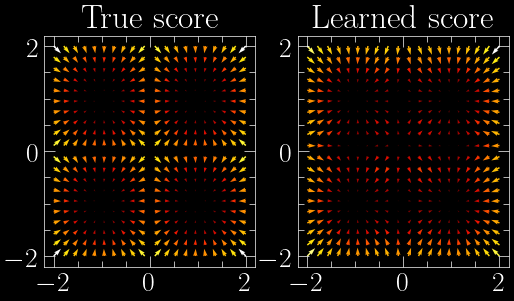

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(6, 3))

learned_score = lambda x: sbm(torch.ones(x.shape[0])*0.1, x)
plot_score(score, ax=axs[0])
axs[0].set_title("True score")
plot_score(learned_score, ax=axs[1])
axs[1].set_title("Learned score")

In [14]:
hnet = MLP(2, width=100, layers=4)
hdm = HessianDiagonal(sbm, hnet, loss="meng")
hdm.fit(dataset, epochs=20, lr=1e-3);

Score model weights are now frozen. This class does not currently support joint optimization.
No path provided. Training checkpoints will not be saved.


Epoch 20 | Cost: 8.2e+06 |: 100%|██████████| 20/20 [02:45<00:00,  8.27s/it]

Finished training after 0.046 hours.


1.49e-43 3.978874


t=0.9 | sigma=4 | x=-0.1±8: 100%|██████████| 20/20 [00:03<00:00,  5.00it/s]    


2.387487e-07 2.6274028
1-net


t=1 | sigma=5 | x=-0.2±1e+01: 100%|██████████| 100/100 [00:16<00:00,  6.13it/s]  

6.897768e-08 0.22088611


Text(0.5, 1.0, 'Hessian model')

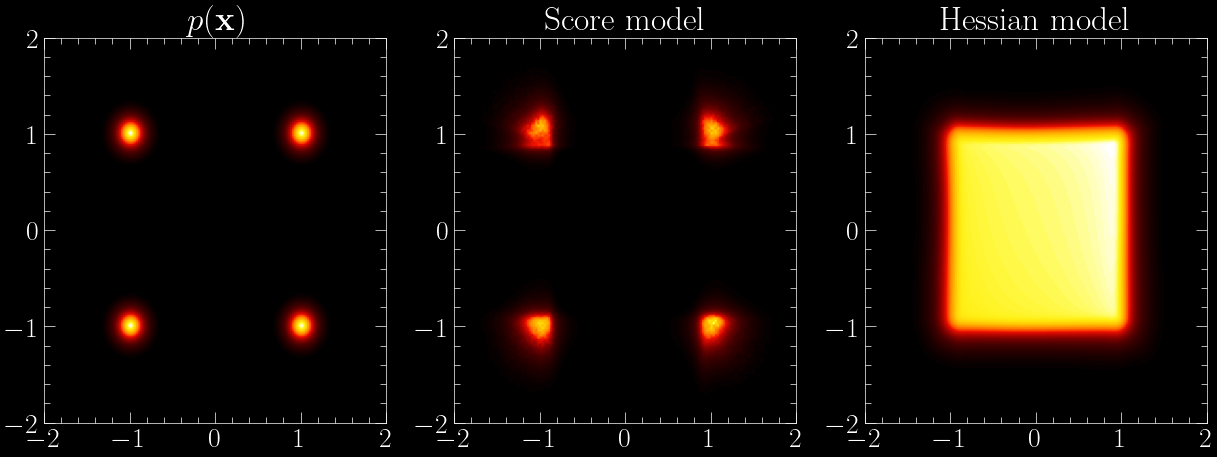

In [22]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
vmax = None
vmin = None
extent = (-2, 2, -2, 2)

ax = axs[0]
plot_density(distribution.log_prob, ax=ax, vmin=vmin, vmax=vmax)
ax.set_title(r"$p(\mathbf{x})$")

ax = axs[1]
plot_density(lambda x: sbm.log_likelihood(x, steps=20), ax=ax, vmin=vmin, vmax=vmax)
ax.set_title("Score model")

# logp = lambda x: hdm(torch.ones(x.shape[0]) * 0.17, x).flatten(1).sum(1)
logp = lambda x: hdm.log_likelihood(x, steps=100)
ax = axs[2]
plot_density(logp, ax=ax, vmin=vmin, vmax=vmax)
ax.set_title("Hessian model")